In [27]:
!cd /data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/705_18_4 && ls -l


total 114276
-rw-rw-r-- 1 1003 1005 28199706 Feb 25 11:26 CT1.nii.gz
-rw-rw-r-- 1 1003 1005 35222909 Feb 25 11:24 FLAIR.nii.gz
-rw-rw-r-- 1 1003 1005 28300099 Feb 25 11:32 T1.nii.gz
-rw-rw-r-- 1 1003 1005 25183053 Feb 25 11:29 T2.nii.gz
-rw-rw-r-- 1 1003 1005    98900 Feb 25 11:24 mask_GTV_FLAIR.nii.gz


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 80
data = sorted(glob("/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/*/mask_GTV_FLAIR.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-2]
    fname = '705_18_4'
    t1 = nib.load(f"/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/{fname}/T1.nii.gz").get_fdata().astype(np.float32)
    t2 = nib.load(f"/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/{fname}/T2.nii.gz").get_fdata().astype(np.float32)
    ct1 = nib.load(f"/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/{fname}/CT1.nii.gz").get_fdata().astype(np.float32)
    flair = nib.load(f"/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/{fname}/FLAIR.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/{fname}/mask_GTV_FLAIR.nii.gz").get_fdata().astype(np.float32)
    z = np.argsort(label.sum(axis=(0,1)))[-1:]
    print(label.shape), print(t1.shape), print(t2.shape)
    print(np.unique(label))
    imgs = [t1[:, :, z]]  + [t2[:, :, z]] + [ct1[:, :, z]]+ [flair[:, :, z]] + [label[:, :, z]]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
    for i in range(5):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

error: Error -3 while decompressing data: invalid stored block lengths

In [35]:
import json
import os
from glob import glob
from glob2 import glob
from subprocess import call
import time
from tqdm import tqdm
import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(f'{directory}/{suffix}.nii.gz')


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["FLAIR", "T1", "CT1", "T2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
#         print(nifty.get_fdata().astype(np.int16).shape)
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d, d_out):
    sub = d.split("/")[-1]
#     sub = '705_18_4'
    print(sub)
    flair, t1, t1ce, t2 = load_channels(d, sub)
    affine, header = flair.affine, flair.header
#     print(flair.get_fdata().dtype),print(t1.get_fdata().dtype), print(t1ce.get_fdata().dtype), print(t2.get_fdata().dtype)
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#     print('l')
#     print( os.path.join(d_out, sub + ".nii.gz"))
    nibabel.save(vol, os.path.join(d_out, sub + ".nii.gz"))
#     print(glob(f'{d}/{sub}/**/MASK.nii.gz')[0])
    if os.path.exists(f'{d}/mask_GTV_FLAIR.nii.gz'):
        seg = load_nifty(d, sub, "mask_GTV_FLAIR")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
#         vol[vol == 4] = 3
#         mask = np.zeros(vol.shape, dtype=np.uint8)
#         mask[vol == 2] = 1
#         mask[vol == 3] = 2
#         mask[vol == 1] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#         print(os.path.join(d_out, sub + "_seg.nii.gz"))
        nibabel.save(seg, os.path.join(d_out, sub + "_seg.nii.gz"))


def prepare_dirs(d_out, train):
    img_path, lbl_path = os.path.join(d_out, "images"), os.path.join(d_out, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(d_out, "*"))
    for d in dirs:
        if '.nii.gz' in d:
                if "FLAIR" in d or "T1" in d or "CT1" in d or "T2" in d:
                    continue
                if "_seg" in d:
                    call(f"mv {d} {lbl_path}", shell=True)
                else:
                    call(f"mv {d} {img_path}", shell=True)
                
#         call(f"rm -rf {d}", shell=True)
         

def prepare_dataset_json(d_out, train):
    images, labels = glob(os.path.join(d_out, "images", "*")), glob(os.path.join(d_out, "labels", "*"))
    images = sorted([img.replace(d_out + "/", "") for img in images])
    labels = sorted([lbl.replace(d_out + "/", "") for lbl in labels])
    
    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(d_out, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train, out):
    print(f"Preparing GBM dataset from: {data}")
    d_out = out
    sub_er = []
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    start = time.time()
#     run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "*"))))
    for each in tqdm(sorted(glob(os.path.join(data, "*")))):
        try:
            print(each)
            if os.path.exists(os.path.join(each, "mask_GTV_FLAIR.nii.gz")):
                prepare_nifty(each, d_out)
        except:
            sub_er.append(each.split("/")[-1])
    print(sub_er)
    prepare_dirs(d_out, train)
    prepare_dataset_json(d_out, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [34]:
sub_er

NameError: name 'sub_er' is not defined

In [36]:
prepare_dataset('/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/',True, '/data/private_data/bgpd/bgpd_4a_resamp')

Preparing GBM dataset from: /data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/


  0%|                                                                                                                                                                       | 0/181 [00:00<?, ?it/s]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1019_18
1019_18


  1%|▉                                                                                                                                                              | 1/181 [00:05<15:40,  5.23s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1028_18_4
1028_18_4


  1%|█▊                                                                                                                                                             | 2/181 [00:08<12:17,  4.12s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1029_18_4
1029_18_4


  2%|██▋                                                                                                                                                            | 3/181 [00:13<13:52,  4.68s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1034_18_4
1034_18_4


  2%|███▌                                                                                                                                                           | 4/181 [00:19<14:26,  4.89s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1036_18
1036_18


  3%|████▍                                                                                                                                                          | 5/181 [00:26<17:07,  5.84s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1043_18_4
1043_18_4


  3%|█████▎                                                                                                                                                         | 6/181 [00:31<16:16,  5.58s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1056_18_4
1056_18_4


  4%|██████▏                                                                                                                                                        | 7/181 [00:36<15:47,  5.45s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1072_19
1072_19


  4%|███████                                                                                                                                                        | 8/181 [00:41<15:14,  5.29s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1096_18
1096_18


  5%|███████▉                                                                                                                                                       | 9/181 [00:45<13:49,  4.82s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1112_19_4
1112_19_4


  6%|████████▋                                                                                                                                                     | 10/181 [00:50<14:04,  4.94s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1159_18_4
1159_18_4


  6%|█████████▌                                                                                                                                                    | 11/181 [00:56<14:16,  5.04s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1164_18
1164_18


  7%|██████████▍                                                                                                                                                   | 12/181 [01:00<14:00,  4.97s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1170_18_4
1170_18_4


  7%|███████████▎                                                                                                                                                  | 13/181 [01:06<14:02,  5.01s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1184_18
1184_18


  8%|████████████▏                                                                                                                                                 | 14/181 [01:11<14:38,  5.26s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1185_18_4
1185_18_4


  8%|█████████████                                                                                                                                                 | 15/181 [01:17<14:27,  5.23s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1214_18
1214_18


  9%|█████████████▉                                                                                                                                                | 16/181 [01:23<15:04,  5.48s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1216_18
1216_18


  9%|██████████████▊                                                                                                                                               | 17/181 [01:26<13:21,  4.89s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1254_18
1254_18


 10%|███████████████▋                                                                                                                                              | 18/181 [01:31<13:03,  4.81s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1255_18
1255_18


 10%|████████████████▌                                                                                                                                             | 19/181 [01:35<12:18,  4.56s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1257_18
1257_18


 11%|█████████████████▍                                                                                                                                            | 20/181 [01:42<14:11,  5.29s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1258_18
1258_18


 12%|██████████████████▎                                                                                                                                           | 21/181 [01:46<13:30,  5.06s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1267_18_4
1267_18_4


 12%|███████████████████▏                                                                                                                                          | 22/181 [01:52<13:38,  5.15s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1275_19_4
1275_19_4


 13%|████████████████████                                                                                                                                          | 23/181 [01:56<12:57,  4.92s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1302_18_4
1302_18_4


 13%|████████████████████▉                                                                                                                                         | 24/181 [02:00<12:11,  4.66s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1326_18
1326_18


 14%|█████████████████████▊                                                                                                                                        | 25/181 [02:02<10:23,  4.00s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1333_18
1333_18


 14%|██████████████████████▋                                                                                                                                       | 26/181 [02:09<12:26,  4.82s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1354_18_4
1354_18_4


 15%|███████████████████████▌                                                                                                                                      | 27/181 [02:13<11:42,  4.56s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1357_19_4
1357_19_4


 15%|████████████████████████▍                                                                                                                                     | 28/181 [02:18<12:01,  4.71s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1360_18
1360_18


 16%|█████████████████████████▎                                                                                                                                    | 29/181 [02:23<12:12,  4.82s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1362_18_4
1362_18_4


 17%|██████████████████████████▏                                                                                                                                   | 30/181 [02:25<10:06,  4.02s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1421_18
1421_18


 17%|███████████████████████████                                                                                                                                   | 31/181 [02:29<09:30,  3.80s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1463_18_4
1463_18_4


 18%|███████████████████████████▉                                                                                                                                  | 32/181 [02:37<12:36,  5.08s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1470_18_4
1470_18_4


 18%|████████████████████████████▊                                                                                                                                 | 33/181 [02:40<10:47,  4.37s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1484_18_4
1484_18_4


 19%|█████████████████████████████▋                                                                                                                                | 34/181 [02:44<10:57,  4.47s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1501_18_4
1501_18_4


 19%|██████████████████████████████▌                                                                                                                               | 35/181 [02:48<10:14,  4.21s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1515_18_4
1515_18_4


 20%|███████████████████████████████▍                                                                                                                              | 36/181 [02:52<10:20,  4.28s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1539_18
1539_18


 20%|████████████████████████████████▎                                                                                                                             | 37/181 [02:58<11:01,  4.59s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1541_18_4
1541_18_4


 21%|█████████████████████████████████▏                                                                                                                            | 38/181 [03:03<11:15,  4.72s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1546_18
1546_18


 22%|██████████████████████████████████                                                                                                                            | 39/181 [03:08<11:43,  4.96s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1566_18
1566_18


 22%|██████████████████████████████████▉                                                                                                                           | 40/181 [03:13<11:45,  5.01s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1573_18_4
1573_18_4


 23%|███████████████████████████████████▊                                                                                                                          | 41/181 [03:17<10:57,  4.70s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1635_18
1635_18


 23%|████████████████████████████████████▋                                                                                                                         | 42/181 [03:20<09:20,  4.03s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1646_18
1646_18


 24%|█████████████████████████████████████▌                                                                                                                        | 43/181 [03:23<08:59,  3.91s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1685_18_4
1685_18_4


 24%|██████████████████████████████████████▍                                                                                                                       | 44/181 [03:30<10:35,  4.64s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1702_18
1702_18


 25%|███████████████████████████████████████▎                                                                                                                      | 45/181 [03:33<09:20,  4.12s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1733_18
1733_18


 25%|████████████████████████████████████████▏                                                                                                                     | 46/181 [03:38<09:59,  4.44s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1734_18
1734_18


 26%|█████████████████████████████████████████                                                                                                                     | 47/181 [03:42<09:40,  4.34s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1743_18_4
1743_18_4


 27%|█████████████████████████████████████████▉                                                                                                                    | 48/181 [03:44<08:19,  3.76s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1744_18
1744_18


 27%|██████████████████████████████████████████▊                                                                                                                   | 49/181 [03:49<09:02,  4.11s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1746_18_4
1746_18_4


 28%|███████████████████████████████████████████▋                                                                                                                  | 50/181 [03:54<09:39,  4.43s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1764_18_4
1764_18_4


 28%|████████████████████████████████████████████▌                                                                                                                 | 51/181 [03:59<09:58,  4.60s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1765_18_4
1765_18_4


 29%|█████████████████████████████████████████████▍                                                                                                                | 52/181 [04:04<10:10,  4.73s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1769_18
1769_18


 29%|██████████████████████████████████████████████▎                                                                                                               | 53/181 [04:09<09:59,  4.68s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1770_18_4
1770_18_4


 30%|███████████████████████████████████████████████▏                                                                                                              | 54/181 [04:13<09:19,  4.41s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1781_18
1781_18


 30%|████████████████████████████████████████████████                                                                                                              | 55/181 [04:18<09:35,  4.57s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1788_18_4
1788_18_4


 31%|████████████████████████████████████████████████▉                                                                                                             | 56/181 [04:20<07:54,  3.80s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/1795_18_
1795_18_


 31%|█████████████████████████████████████████████████▊                                                                                                            | 57/181 [04:26<09:42,  4.70s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/255_18
255_18


 32%|██████████████████████████████████████████████████▋                                                                                                           | 58/181 [04:31<09:20,  4.56s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/322_18_4
322_18_4


 33%|███████████████████████████████████████████████████▌                                                                                                          | 59/181 [04:35<09:13,  4.53s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/349_18_4
349_18_4


 33%|████████████████████████████████████████████████████▍                                                                                                         | 60/181 [04:37<07:39,  3.80s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/351_18
351_18


 34%|█████████████████████████████████████████████████████▏                                                                                                        | 61/181 [04:40<07:00,  3.51s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/423_18
423_18


 34%|██████████████████████████████████████████████████████                                                                                                        | 62/181 [04:45<07:48,  3.94s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/541_18
541_18


 35%|██████████████████████████████████████████████████████▉                                                                                                       | 63/181 [04:48<06:54,  3.52s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/558_18_4
558_18_4


 35%|███████████████████████████████████████████████████████▊                                                                                                      | 64/181 [04:50<06:21,  3.26s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/573_18_4
573_18_4


 36%|████████████████████████████████████████████████████████▋                                                                                                     | 65/181 [04:54<06:47,  3.52s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/575_18_4
575_18_4


 36%|█████████████████████████████████████████████████████████▌                                                                                                    | 66/181 [04:57<06:03,  3.16s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/593_18
593_18


 37%|██████████████████████████████████████████████████████████▍                                                                                                   | 67/181 [05:02<07:27,  3.92s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/607_18
607_18


 38%|███████████████████████████████████████████████████████████▎                                                                                                  | 68/181 [05:08<08:07,  4.31s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/608_18_4
608_18_4


 38%|████████████████████████████████████████████████████████████▏                                                                                                 | 69/181 [05:13<08:33,  4.58s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/644_19_4
644_19_4


 39%|█████████████████████████████████████████████████████████████                                                                                                 | 70/181 [05:16<07:38,  4.13s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/660_18_4
660_18_4


 39%|█████████████████████████████████████████████████████████████▉                                                                                                | 71/181 [05:21<08:15,  4.50s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/664_18_4
664_18_4


 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 72/181 [05:26<08:26,  4.65s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/668_18_4
668_18_4


 40%|███████████████████████████████████████████████████████████████▋                                                                                              | 73/181 [05:31<08:30,  4.73s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/672_18_4
672_18_4


 41%|████████████████████████████████████████████████████████████████▌                                                                                             | 74/181 [05:38<09:23,  5.26s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/688_18
688_18


 41%|█████████████████████████████████████████████████████████████████▍                                                                                            | 75/181 [05:43<09:15,  5.24s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/705_18_4
705_18_4


 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 76/181 [05:43<06:45,  3.86s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/745_18_4
745_18_4


 43%|███████████████████████████████████████████████████████████████████▏                                                                                          | 77/181 [05:50<08:06,  4.68s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/746_19_4
746_19_4


 43%|████████████████████████████████████████████████████████████████████                                                                                          | 78/181 [05:55<08:18,  4.84s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/770_18
770_18


 44%|████████████████████████████████████████████████████████████████████▉                                                                                         | 79/181 [05:59<07:49,  4.60s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/788_18
788_18


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 80/181 [06:04<08:01,  4.77s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/826_18_4
826_18_4


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                       | 81/181 [06:11<08:51,  5.32s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/856_19_4
856_19_4


 45%|███████████████████████████████████████████████████████████████████████▌                                                                                      | 82/181 [06:16<08:47,  5.33s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/875_18_4
875_18_4


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                     | 83/181 [06:17<06:34,  4.03s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/923_18
923_18


 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                    | 84/181 [06:23<07:02,  4.36s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/925_18_4
925_18_4


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                   | 85/181 [06:28<07:17,  4.56s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/946_18
946_18


 48%|███████████████████████████████████████████████████████████████████████████                                                                                   | 86/181 [06:33<07:26,  4.70s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/971_18_4
971_18_4


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                  | 87/181 [06:37<07:23,  4.71s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/979_18_4
979_18_4


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                 | 88/181 [06:42<07:19,  4.73s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/990_18_4
990_18_4


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                | 89/181 [06:45<06:35,  4.30s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_1000314
Patient_1000314


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                               | 90/181 [06:50<06:32,  4.31s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_1000815
Patient_1000815


 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 91/181 [06:53<05:57,  3.97s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_1001316
Patient_1001316


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                             | 92/181 [06:53<04:17,  2.89s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_102117
Patient_102117


 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                            | 93/181 [06:57<04:41,  3.20s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_103717
Patient_103717


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                            | 94/181 [07:01<05:04,  3.50s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_104514
Patient_104514


 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                           | 95/181 [07:05<05:08,  3.59s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_105215
Patient_105215


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                          | 96/181 [07:09<05:07,  3.61s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_107017
Patient_107017


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 97/181 [07:14<05:52,  4.20s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_109017
Patient_109017


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 98/181 [07:19<05:47,  4.19s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_109414
Patient_109414


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 99/181 [07:23<05:36,  4.10s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_110014
Patient_110014


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 100/181 [07:25<04:56,  3.66s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_110816
Patient_110816


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 101/181 [07:29<05:04,  3.80s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_111016
Patient_111016


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 102/181 [07:33<04:48,  3.66s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_120115
Patient_120115


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 103/181 [07:33<03:38,  2.81s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_12115
Patient_12115


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 104/181 [07:37<03:43,  2.90s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_12214
Patient_12214


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 105/181 [07:40<03:50,  3.03s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_122315
Patient_122315


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 106/181 [07:44<04:17,  3.44s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_123816
Patient_123816


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 107/181 [07:48<04:30,  3.66s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_12417
Patient_12417


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 108/181 [07:52<04:23,  3.61s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_127916
Patient_127916


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 109/181 [07:56<04:19,  3.60s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_129316
Patient_129316


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 110/181 [07:59<04:18,  3.65s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_129415
Patient_129415


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 111/181 [08:04<04:46,  4.09s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_129816
Patient_129816


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 112/181 [08:08<04:27,  3.87s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_130514
Patient_130514


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 113/181 [08:12<04:20,  3.84s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_131416
Patient_131416


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 114/181 [08:14<03:59,  3.57s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_132216
Patient_132216


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 115/181 [08:19<04:07,  3.75s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_133916
Patient_133916


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 116/181 [08:22<04:02,  3.73s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_135915
Patient_135915


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 117/181 [08:27<04:14,  3.97s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_136415
Patient_136415


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 118/181 [08:31<04:13,  4.02s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_136715
Patient_136715


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 119/181 [08:34<03:56,  3.81s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_136915
Patient_136915


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 120/181 [08:37<03:38,  3.58s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_137315
Patient_137315


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 121/181 [08:41<03:37,  3.62s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_138316
Patient_138316


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 122/181 [08:48<04:40,  4.76s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_138516
Patient_138516


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 123/181 [08:52<04:10,  4.32s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_140316
Patient_140316


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 124/181 [08:55<03:52,  4.08s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_146716
Patient_146716


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 125/181 [08:59<03:35,  3.85s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_15215
Patient_15215


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 126/181 [09:03<03:33,  3.88s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_15817
Patient_15817


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 127/181 [09:06<03:20,  3.71s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_158716
Patient_158716


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 128/181 [09:10<03:23,  3.83s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_161316
Patient_161316


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 129/181 [09:14<03:17,  3.80s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_1815
Patient_1815


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 130/181 [09:17<02:59,  3.53s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_20717
Patient_20717


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 131/181 [09:20<02:57,  3.55s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_22117
Patient_22117


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 132/181 [09:23<02:47,  3.43s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_24117
Patient_24117


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 133/181 [09:27<02:45,  3.45s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_24717
Patient_24717


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 134/181 [09:31<02:56,  3.75s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_24815
Patient_24815


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 135/181 [09:35<02:55,  3.81s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_28514
Patient_28514


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 136/181 [09:40<02:57,  3.95s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_2914
Patient_2914


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 137/181 [09:43<02:48,  3.82s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_33217
Patient_33217


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 138/181 [09:47<02:52,  4.01s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_43316
Patient_43316


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 139/181 [09:52<02:55,  4.19s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_43515
Patient_43515


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 140/181 [09:57<02:55,  4.28s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_45217
Patient_45217


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 141/181 [10:01<02:48,  4.22s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_48417
Patient_48417


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 142/181 [10:02<02:09,  3.31s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_48517
Patient_48517


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 143/181 [10:04<01:55,  3.03s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_49617
Patient_49617


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 144/181 [10:09<02:08,  3.46s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_5117
Patient_5117


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 145/181 [10:12<02:02,  3.42s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_51815
Patient_51815


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 146/181 [10:16<02:09,  3.71s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_52315
Patient_52315


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 147/181 [10:20<02:07,  3.74s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_54317
Patient_54317


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 148/181 [10:25<02:12,  4.03s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_56717
Patient_56717


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 149/181 [10:28<01:59,  3.72s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_59315
Patient_59315


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 150/181 [10:31<01:51,  3.60s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_59817
Patient_59817


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 151/181 [10:35<01:47,  3.58s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_61715
Patient_61715


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 152/181 [10:38<01:37,  3.37s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_61916
Patient_61916


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 153/181 [10:42<01:40,  3.57s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_62315
Patient_62315


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 154/181 [10:46<01:40,  3.74s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_62817
Patient_62817


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 155/181 [10:49<01:31,  3.51s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_65516
Patient_65516


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 156/181 [10:53<01:30,  3.62s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_66615
Patient_66615


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 157/181 [10:57<01:33,  3.88s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_69515
Patient_69515


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 158/181 [11:02<01:33,  4.09s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_70614
Patient_70614


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 159/181 [11:04<01:20,  3.66s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_716
Patient_716


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 160/181 [11:08<01:15,  3.57s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_72715
Patient_72715


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 161/181 [11:11<01:12,  3.62s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_74417
Patient_74417


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 162/181 [11:16<01:12,  3.82s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_75116
Patient_75116


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 163/181 [11:19<01:08,  3.78s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_76516
Patient_76516


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 164/181 [11:23<01:00,  3.58s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_8017
Patient_8017


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 165/181 [11:26<00:56,  3.51s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_83217
Patient_83217


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 166/181 [11:29<00:50,  3.34s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_83714
Patient_83714


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 167/181 [11:32<00:47,  3.40s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_84116
Patient_84116


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 168/181 [11:36<00:46,  3.61s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_87114
Patient_87114


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 169/181 [11:39<00:41,  3.42s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_88817
Patient_88817


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 170/181 [11:44<00:41,  3.77s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_88917
Patient_88917


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 171/181 [11:49<00:39,  3.99s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_89117
Patient_89117


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 172/181 [12:01<00:57,  6.41s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_90517
Patient_90517


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 173/181 [12:04<00:43,  5.45s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_90616
Patient_90616


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 174/181 [12:07<00:34,  4.87s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_92114
Patient_92114


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 175/181 [12:11<00:26,  4.43s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_9315
Patient_9315


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 176/181 [12:15<00:21,  4.26s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_95717
Patient_95717


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 177/181 [12:19<00:17,  4.30s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_98814
Patient_98814


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 178/181 [12:22<00:11,  3.87s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_98817
Patient_98817


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 179/181 [12:26<00:07,  3.96s/it]

/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/Patient_99715
Patient_99715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [12:29<00:00,  4.14s/it]
mkdir: cannot create directory ‘/data/private_data/bgpd/bgpd_4a_resamp/images’: File exists
mkdir: cannot create directory ‘/data/private_data/bgpd/bgpd_4a_resamp/labels’: File exists


/data_anvar/public_datasets/preproc_study/bgpd/4a_resamp/logging.txt
['705_18_4', '875_18_4', 'Patient_1001316', 'Patient_120115', 'Patient_48417']
Preparing time: 757.88


In [16]:
!cd /data/private_data && mv bgpd bgpd_1_reg

In [26]:
!python3 ../preprocess.py --data /data/private_data/ --task 35 --ohe --exec_mode training --results /data/private_data/

Preprocessing /data/private_data/bgpd_2a_interp
Traceback (most recent call last):
  File "../preprocess.py", line 42, in <module>
    Preprocessor(args).run()
  File "/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/data_preprocessing/preprocessor.py", line 87, in run
    self.run_parallel(self.preprocess_pair, self.args.exec_mode)
  File "/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/data_preprocessing/preprocessor.py", line 250, in run_parallel
    return Parallel(n_jobs=self.args.n_jobs)(delayed(func)(pair) for pair in self.metadata[exec_mode])
  File "/opt/conda/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/opt/conda/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/opt/conda/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "

In [39]:
import pandas as pd
m = pd.read_csv('/results/bgpd_infer/bgpd_1reg/metrics_bgpd_1reg_fold-0.csv')
m.mean()

Unnamed: 0        NaN
Ids               NaN
Dice_1            NaN
Dice_2            NaN
Dice_3            NaN
Hausdorff95_1     NaN
Hausdorff95_2     NaN
Hausdorff95_3     NaN
Sensitivity_1     NaN
Sensitivity_2     NaN
Sensitivity_3     NaN
Specificity_1     NaN
Specificity_2     NaN
Specificity_3     NaN
Surface_dice_1    NaN
Surface_dice_2    NaN
Surface_dice_3    NaN
Precision_1       NaN
Precision_2       NaN
Precision_3       NaN
dtype: object

1019_18
(240, 501, 512, 1)
[0 1]
(240, 501, 512, 5)


TypeError: Invalid shape (240, 501, 1, 1) for image data

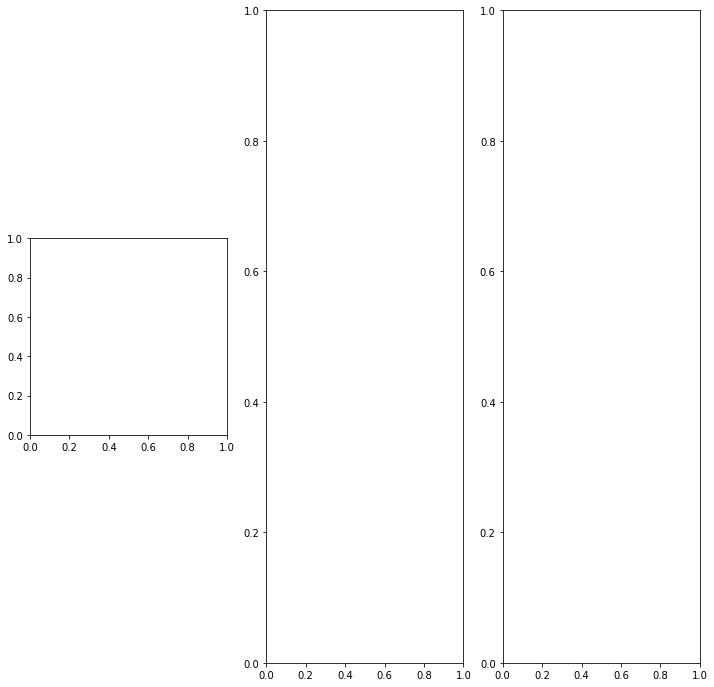

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 40
data = sorted(glob("/data/private_data/bgpd_1_reg/images/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = np.load(f"/data/private_data/34_3d/{fname}_x.npy").astype(np.float32).transpose(3,2,1,0)
    label = np.load(f"/data/private_data/34_3d/{fname}_y.npy").astype(np.uint8).transpose(3,2,1,0)
#     pred = np.round(pred, 0).transpose(3,2,1,0)
#     print(label.sum(axis=(0,1)))
#     print(np.argsort(label.sum(axis=(0,1))))
    z = np.argsort(label.sum(axis=(1,2)))[-1:]
#     print(z[-1:])
    print(label.shape), print(np.unique(label))
    print(img.shape)
    imgs = [img[:, :, z,i] for i in [0, 1]] + [label[:, :, z, 0]]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()